In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


import sys
sys.path.insert(0, "../scripts")
from helpers import *

In [ ]:
des_data0 = [(i,j,k) for i, j,k, in zip(["Zone Mean Air Temperature"]*3 + ["Site Outdoor Air Drybulb Temperature"] , [0,1, 2, 0], ["East Zone", "North Zone","West Zone", "Out",])]

des_data = [(i,j,k) for i, j,k, in zip(["Zone Mean Air Temperature"]*3 + ["Site Outdoor Air Drybulb Temperature"] + ["AFN Zone Ventilation Mass"]*3 + ["AFN Surface Venting Window or Door Opening Factor"]*2, [0,1, 2, 0, 0, 1, 2, 1, 5], ["East Zone", "North Zone","West Zone", "Out", "E-VentMass", "N-VentMass", "W-VentMass", "EastWindow", "WestWindow"])]

In [6]:
dir = "../rosseRoomModel/230307/test00/eplusout.sql"
t00 = LoadSQL(dir, "test00 - window var")
t00.get_valid_data(des_data0);

In [7]:
dir = "../rosseRoomModel/230307/test01/eplusout.sql"
t01 = LoadSQL(dir, "test01 - window var")
t01.get_valid_data(des_data0);

In [33]:
df00 = pd.DataFrame(t00.data["West Zone"].values, index=pd.to_datetime(t00.data["West Zone"].datetimes))

df01 = pd.DataFrame(t01.data["West Zone"].values, index=pd.to_datetime(t01.data["West Zone"].datetimes))
df00

,0
2017-07-20 00:00:00,22.067189
2017-07-20 00:15:00,22.050305
2017-07-20 00:30:00,22.035163
2017-07-20 00:45:00,22.020159
2017-07-20 01:00:00,22.001794
...,...
2017-07-24 22:45:00,23.603685
2017-07-24 23:00:00,23.583059
2017-07-24 23:15:00,23.561852
2017-07-24 23:30:00,23.540176


In [31]:
# period => # samples per unit in length of time over which seasonality occurs (here, 4 samples/1 hour) * length of length of time over which seasonality occurs (here, 24 hours)
n_samples = 4
seasonality_period = 24
period = n_samples*seasonality_period
period

96

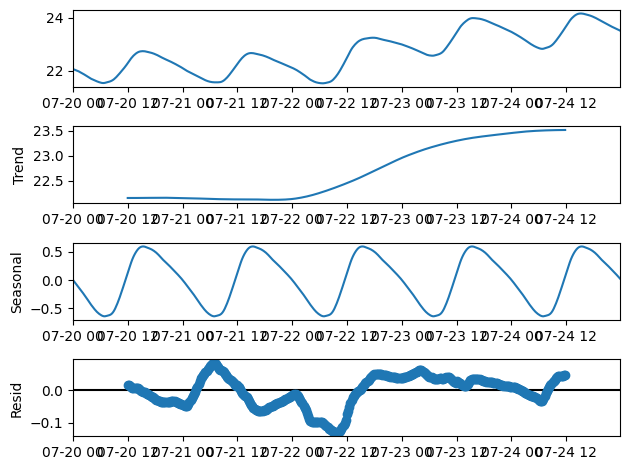

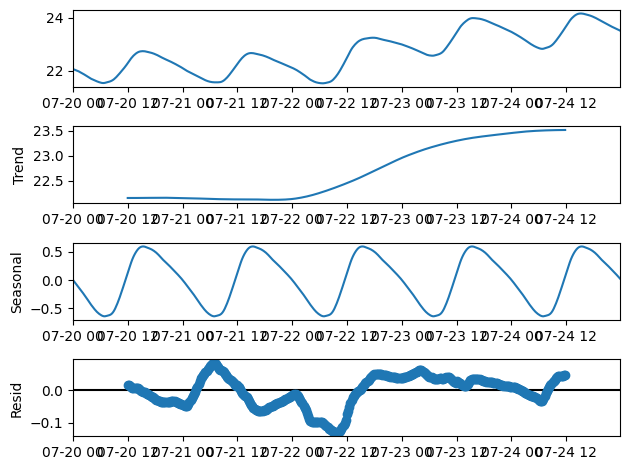

In [32]:
results = seasonal_decompose(df00,model='additive', period=period)
results.plot()

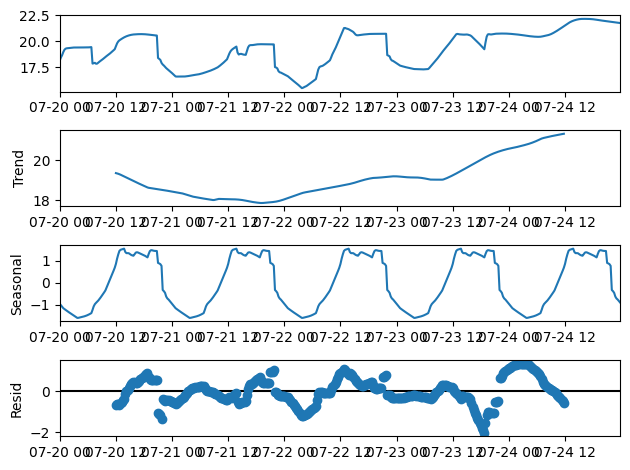

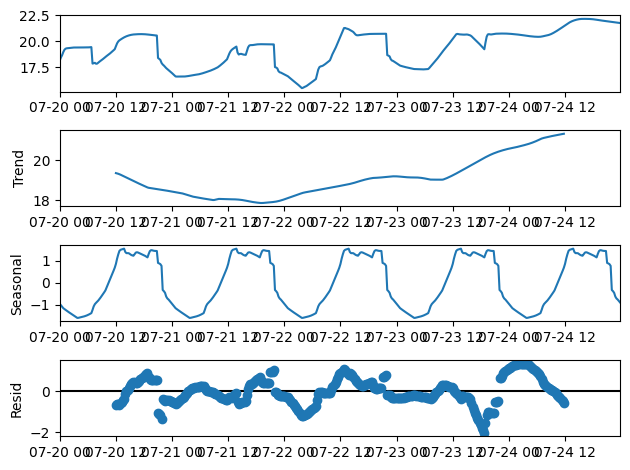

In [34]:
results01 = seasonal_decompose(df01,model='additive', period=period)
results01.plot()